In [4]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad
import multiprocessing as mp
import gc
import matplotlib.colors as colors
from matplotlib import rcParams 
from scipy.stats import gaussian_kde
from scipy.stats import binned_statistic_2d
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

In [5]:
plt.rc('font',size=25)
pd.set_option('max_column',200)

In [6]:
plt.rcParams.update({'figure.figsize': (6, 6),
                   'font.size':25,
                   'text.usetex':True,
                   'mathtext.default' : 'it',
                   'axes.labelsize': 32,
                   'legend.fontsize': 25,
                   'legend.fancybox': False,
                   'legend.numpoints': 1,
                   'xtick.labelsize': 32,
                   'ytick.labelsize': 32,
                   'ytick.major.width':0.8,
                   'ytick.major.size':8,
                   'ytick.minor.size':4,
                   'xtick.major.width': 0.8,
                   'xtick.major.size':8,
                   'xtick.minor.size':4,
                   'axes.linewidth':2,
                   'lines.linewidth':2,
                   'xtick.direction':'in',
                   'ytick.direction':'in',
                   'savefig.bbox': 'tight', # 'tight' or 'standard'.
                   'savefig.pad_inches' : 0.1})
plt.rc('font',**{'family':'serif','serif':['Computer Modern'],'sans-serif':['Computer Modern']})

from matplotlib.ticker import FuncFormatter
#%matplotlib inline

import glob

In [4]:
# given vectors x and y, fit medians in bins from xMin to xMax, with Nbin steps,
# and return xBin, medianBin, medianErrBin 
def fitMedians(x, y, xMin, xMax, Nbin, verbose=1): 

    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    medianBin = 0*np.linspace(0, 1, Nbin)
    sigGbin = [-1+0*np.linspace(0, 1, Nbin),-1+0*np.linspace(0, 1, Nbin)] #lower and upper
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux1 = y[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = ye[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = yErr[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
        if (yAux1.size > 0):
            yAux = yAux1#[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
            nPts[i] = yAux.size
            medianBin[i] = np.median(yAux) #mean
            # robust estimate of standard deviation: 0.741*(q75-q50),0.741*(q50-q25)
            sigmaG1 = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,50))*2
            sigmaG2 = 0.741*(np.percentile(yAux,50)-np.percentile(yAux,25))*2
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
            sigGbin[0][i] = np.sqrt(np.pi/2)*sigmaG2/np.sqrt(nPts[i])
            sigGbin[1][i] = np.sqrt(np.pi/2)*sigmaG1/np.sqrt(nPts[i])
        else:
            nPts[i] = 0 
            medianBin[i] = np.nan
            sigGbin[0][i] = np.nan
            sigGbin[1][i] = np.nan 
            # nPts[i], medianBin[i], sigGBin[i] = 0 
        
    if (verbose):
        print('median:', np.median(medianBin[nPts>0]))

    return xBin, nPts, medianBin, sigGbin

In [633]:
ms=pd.read_csv('../Downloads/catalog/final/starall.csv')

In [466]:
gg=[]
rg=[]
ig=[]
for g in np.arange(17,24.1,0.05):
    t1=ms[(ms.g_psfflux_mag>g-0.1)&(ms.g_psfflux_mag<g+0.1)]
    for r in np.arange(17,24.1,0.05):
        x0=np.inf
        t=t1[(t1.r_psfflux_mag>r-0.1)&(t1.r_psfflux_mag<r+0.1)]#&(ms.i_psfflux_mag>i-0.3)&(ms.i_psfflux_mag<i+0.3)]
        if len(t)<500:
            continue
        i=np.median(t.i_psfflux_mag)
        gg.append(g)
        rg.append(r)
        ig.append(i)
        print(len(t),g,r,i)
'''        for i in np.arange(17,24.1,0.05):
            x2=sum((t.r_psfflux_mag-r)**2/t.r_psfflux_magsigma**2+(t.g_psfflux_mag-g)**2/t.g_psfflux_magsigma**2+(t.i_psfflux_mag-i)**2/t.i_psfflux_magsigma**2)
            if x2<x0:
                x0=x2
                rm=r
                gm=g
                im=i
        gg.append(gm)
        rg.append(rm)
        ig.append(im)'''


539 19.00000000000003 18.600000000000023 18.4816093
557 19.00000000000003 18.650000000000023 18.530462300000003
516 19.00000000000003 18.700000000000024 18.57653235
536 19.05000000000003 18.600000000000023 18.473430649999997
615 19.05000000000003 18.650000000000023 18.5310478
634 19.05000000000003 18.700000000000024 18.579543100000002
586 19.05000000000003 18.750000000000025 18.6184845
539 19.10000000000003 18.600000000000023 18.4499283
634 19.10000000000003 18.650000000000023 18.521212600000002
704 19.10000000000003 18.700000000000024 18.579237900000003
716 19.10000000000003 18.750000000000025 18.62501335
618 19.10000000000003 18.800000000000026 18.668550500000002
609 19.15000000000003 18.650000000000023 18.4962502
718 19.15000000000003 18.700000000000024 18.56590655
794 19.15000000000003 18.750000000000025 18.62100315
764 19.15000000000003 18.800000000000026 18.67014025
661 19.15000000000003 18.850000000000026 18.714756
585 19.20000000000003 18.650000000000023 18.4788437
697 19.20000

551 19.90000000000004 19.00000000000003 18.645515399999997
641 19.90000000000004 19.05000000000003 18.7201252
710 19.90000000000004 19.10000000000003 18.796892149999998
768 19.90000000000004 19.15000000000003 18.86272905
860 19.90000000000004 19.20000000000003 18.9307146
972 19.90000000000004 19.250000000000032 19.012792599999997
1078 19.90000000000004 19.300000000000033 19.0786333
1191 19.90000000000004 19.350000000000033 19.1503582
1317 19.90000000000004 19.400000000000034 19.216686199999998
1427 19.90000000000004 19.450000000000035 19.2987404
1542 19.90000000000004 19.500000000000036 19.3706493
1501 19.90000000000004 19.550000000000036 19.422245
1345 19.90000000000004 19.600000000000037 19.4615326
1004 19.90000000000004 19.650000000000038 19.502014199999998
656 19.90000000000004 19.70000000000004 19.554829599999998
536 19.950000000000042 19.00000000000003 18.617585199999997
617 19.950000000000042 19.05000000000003 18.6961803
679 19.950000000000042 19.10000000000003 18.77767560000000

559 20.300000000000047 19.00000000000003 18.274311100000002
727 20.300000000000047 19.05000000000003 18.3983727
814 20.300000000000047 19.10000000000003 18.499128350000003
895 20.300000000000047 19.15000000000003 18.5875263
854 20.300000000000047 19.20000000000003 18.68504715
820 20.300000000000047 19.250000000000032 18.783342349999998
806 20.300000000000047 19.300000000000033 18.86200235
778 20.300000000000047 19.350000000000033 18.94491765
801 20.300000000000047 19.400000000000034 19.0238228
790 20.300000000000047 19.450000000000035 19.10205745
802 20.300000000000047 19.500000000000036 19.1708803
839 20.300000000000047 19.550000000000036 19.2510796
888 20.300000000000047 19.600000000000037 19.3239174
1014 20.300000000000047 19.650000000000038 19.405942
1136 20.300000000000047 19.70000000000004 19.4807415
1345 20.300000000000047 19.75000000000004 19.559753399999998
1584 20.300000000000047 19.80000000000004 19.62996005
1794 20.300000000000047 19.85000000000004 19.70490455
1983 20.30000

1725 20.650000000000052 20.150000000000045 19.9872284
2006 20.650000000000052 20.200000000000045 20.0612383
2240 20.650000000000052 20.250000000000046 20.1258907
2280 20.650000000000052 20.300000000000047 20.17554665
2040 20.650000000000052 20.350000000000048 20.22093105
1566 20.650000000000052 20.40000000000005 20.2566805
1029 20.650000000000052 20.45000000000005 20.3006802
610 20.650000000000052 20.50000000000005 20.3447809
751 20.700000000000053 19.300000000000033 18.4622879
1281 20.700000000000053 19.350000000000033 18.530481299999998
1737 20.700000000000053 19.400000000000034 18.605587
1969 20.700000000000053 19.450000000000035 18.6965485
1932 20.700000000000053 19.500000000000036 18.799474699999998
1666 20.700000000000053 19.550000000000036 18.928154900000003
1381 20.700000000000053 19.600000000000037 19.050489399999996
1174 20.700000000000053 19.650000000000038 19.1562481
1002 20.700000000000053 19.70000000000004 19.24221325
928 20.700000000000053 19.75000000000004 19.3258504999

760 20.950000000000056 20.100000000000044 19.738874449999997
775 20.950000000000056 20.150000000000045 19.820323899999998
799 20.950000000000056 20.200000000000045 19.896171600000002
881 20.950000000000056 20.250000000000046 19.971485100000002
1018 20.950000000000056 20.300000000000047 20.057540900000003
1177 20.950000000000056 20.350000000000048 20.130737300000003
1441 20.950000000000056 20.40000000000005 20.213472399999997
1826 20.950000000000056 20.45000000000005 20.29328725
2193 20.950000000000056 20.50000000000005 20.367897
2542 20.950000000000056 20.55000000000005 20.427551299999998
2663 20.950000000000056 20.60000000000005 20.479063
2384 20.950000000000056 20.650000000000052 20.522371300000003
1848 20.950000000000056 20.700000000000053 20.562364600000002
1196 20.950000000000056 20.750000000000053 20.6018562
667 20.950000000000056 20.800000000000054 20.6446419
865 21.000000000000057 19.550000000000036 18.6048508
1712 21.000000000000057 19.600000000000037 18.67802715
2559 21.00000

712 21.30000000000006 19.80000000000004 18.74597265
1625 21.30000000000006 19.85000000000004 18.807733499999998
2958 21.30000000000006 19.90000000000004 18.85723495
4126 21.30000000000006 19.950000000000042 18.91374775
4820 21.30000000000006 20.000000000000043 18.97530175
4654 21.30000000000006 20.050000000000043 19.059826850000004
3672 21.30000000000006 20.100000000000044 19.1830883
2637 21.30000000000006 20.150000000000045 19.3650837
1704 21.30000000000006 20.200000000000045 19.5866871
1179 21.30000000000006 20.250000000000046 19.7311573
997 21.30000000000006 20.300000000000047 19.827773999999998
864 21.30000000000006 20.350000000000048 19.91365055
810 21.30000000000006 20.40000000000005 19.9962025
764 21.30000000000006 20.45000000000005 20.0800457
743 21.30000000000006 20.50000000000005 20.1590023
823 21.30000000000006 20.55000000000005 20.2450771
926 21.30000000000006 20.60000000000005 20.33416555
1110 21.30000000000006 20.650000000000052 20.413540849999997
1341 21.30000000000006 2

800 21.550000000000065 21.400000000000063 21.2488308
1192 21.600000000000065 20.100000000000044 18.931884750000002
2502 21.600000000000065 20.150000000000045 18.999420200000003
4151 21.600000000000065 20.200000000000045 19.072284699999997
5573 21.600000000000065 20.250000000000046 19.1349602
6189 21.600000000000065 20.300000000000047 19.207008399999996
5743 21.600000000000065 20.350000000000048 19.2907181
4451 21.600000000000065 20.40000000000005 19.4151688
3050 21.600000000000065 20.45000000000005 19.643177
1911 21.600000000000065 20.50000000000005 19.875137300000002
1247 21.600000000000065 20.55000000000005 20.0193348
1007 21.600000000000065 20.60000000000005 20.1182137
874 21.600000000000065 20.650000000000052 20.2175961
831 21.600000000000065 20.700000000000053 20.3028736
828 21.600000000000065 20.750000000000053 20.383132000000003
844 21.600000000000065 20.800000000000054 20.4613657
886 21.600000000000065 20.850000000000055 20.52657695
999 21.600000000000065 20.900000000000055 20.

7197 21.85000000000007 20.55000000000005 19.4146156
6401 21.85000000000007 20.60000000000005 19.5087128
4873 21.85000000000007 20.650000000000052 19.644865
3255 21.85000000000007 20.700000000000053 19.871547699999997
1994 21.85000000000007 20.750000000000053 20.1120243
1365 21.85000000000007 20.800000000000054 20.2636337
1046 21.85000000000007 20.850000000000055 20.377099
930 21.85000000000007 20.900000000000055 20.463521999999998
880 21.85000000000007 20.950000000000056 20.548995950000002
826 21.85000000000007 21.000000000000057 20.63161375
859 21.85000000000007 21.050000000000058 20.713413199999998
938 21.85000000000007 21.10000000000006 20.802083
1058 21.85000000000007 21.15000000000006 20.8827639
1303 21.85000000000007 21.20000000000006 20.963466600000004
1568 21.85000000000007 21.25000000000006 21.035161
1975 21.85000000000007 21.30000000000006 21.1122398
2463 21.85000000000007 21.350000000000062 21.190414399999998
2880 21.85000000000007 21.400000000000063 21.258314149999997
3146 

5499 22.150000000000073 20.950000000000056 19.899642899999996
3615 22.150000000000073 21.000000000000057 20.0954933
2129 22.150000000000073 21.050000000000058 20.388984699999998
1344 22.150000000000073 21.10000000000006 20.55842785
1040 22.150000000000073 21.15000000000006 20.670816450000004
962 22.150000000000073 21.20000000000006 20.764143949999998
887 22.150000000000073 21.25000000000006 20.8480358
919 22.150000000000073 21.30000000000006 20.9294968
985 22.150000000000073 21.350000000000062 21.0192337
1083 22.150000000000073 21.400000000000063 21.0983448
1282 22.150000000000073 21.450000000000063 21.171677600000002
1531 22.150000000000073 21.500000000000064 21.259124800000002
1840 22.150000000000073 21.550000000000065 21.33226965
2280 22.150000000000073 21.600000000000065 21.414582250000002
2779 22.150000000000073 21.650000000000066 21.4851475
3203 22.150000000000073 21.700000000000067 21.554081
3379 22.150000000000073 21.750000000000068 21.6051521
3144 22.150000000000073 21.8000000

6805 22.450000000000077 21.050000000000058 19.8287697
8527 22.450000000000077 21.10000000000006 19.8996468
8956 22.450000000000077 21.15000000000006 19.97812365
7868 22.450000000000077 21.20000000000006 20.05291555
5754 22.450000000000077 21.25000000000006 20.14329625
3682 22.450000000000077 21.30000000000006 20.345205299999996
2168 22.450000000000077 21.350000000000062 20.6866169
1369 22.450000000000077 21.400000000000063 20.875865899999997
1147 22.450000000000077 21.450000000000063 20.9711266
1014 22.450000000000077 21.500000000000064 21.05367945
964 22.450000000000077 21.550000000000065 21.147069000000002
946 22.450000000000077 21.600000000000065 21.224901200000005
1023 22.450000000000077 21.650000000000066 21.319627800000006
1187 22.450000000000077 21.700000000000067 21.4067745
1430 22.450000000000077 21.750000000000068 21.4809513
1755 22.450000000000077 21.800000000000068 21.556861899999998
2150 22.450000000000077 21.85000000000007 21.6345911
2595 22.450000000000077 21.90000000000

1250 22.75000000000008 21.20000000000006 19.80966
2783 22.75000000000008 21.25000000000006 19.9200516
5174 22.75000000000008 21.30000000000006 20.022228249999998
7688 22.75000000000008 21.350000000000062 20.10741615
9435 22.75000000000008 21.400000000000063 20.1844044
9799 22.75000000000008 21.450000000000063 20.2535458
8421 22.75000000000008 21.500000000000064 20.3203449
6162 22.75000000000008 21.550000000000065 20.4138222
3985 22.75000000000008 21.600000000000065 20.6022816
2357 22.75000000000008 21.650000000000066 20.9967766
1541 22.75000000000008 21.700000000000067 21.172657
1249 22.75000000000008 21.750000000000068 21.282213199999997
1159 22.75000000000008 21.800000000000068 21.3658676
1153 22.75000000000008 21.85000000000007 21.451465600000002
1194 22.75000000000008 21.90000000000007 21.53798775
1271 22.75000000000008 21.95000000000007 21.6185951
1461 22.75000000000008 22.00000000000007 21.7005444
1678 22.75000000000008 22.05000000000007 21.78132625
1977 22.75000000000008 22.1000

567 23.050000000000086 21.450000000000063 19.978961899999998
1486 23.050000000000086 21.500000000000064 20.0868254
3115 23.050000000000086 21.550000000000065 20.1955891
5721 23.050000000000086 21.600000000000065 20.3004112
8437 23.050000000000086 21.650000000000066 20.3955727
10255 23.050000000000086 21.700000000000067 20.4719925
10710 23.050000000000086 21.750000000000068 20.540374749999998
9255 23.050000000000086 21.800000000000068 20.6119003
6729 23.050000000000086 21.85000000000007 20.7008896
4386 23.050000000000086 21.90000000000007 20.873477
2607 23.050000000000086 21.95000000000007 21.2893314
1647 23.050000000000086 22.00000000000007 21.4638786
1362 23.050000000000086 22.05000000000007 21.5738602
1248 23.050000000000086 22.100000000000072 21.661935800000002
1279 23.050000000000086 22.150000000000073 21.7594299
1364 23.050000000000086 22.200000000000074 21.845982550000002
1473 23.050000000000086 22.250000000000075 21.9210854
1686 23.050000000000086 22.300000000000075 21.9991751
1

649 23.30000000000009 21.700000000000067 20.2231007
1682 23.30000000000009 21.750000000000068 20.324508699999996
3535 23.30000000000009 21.800000000000068 20.449216800000002
6244 23.30000000000009 21.85000000000007 20.5630856
9060 23.30000000000009 21.90000000000007 20.643260950000002
11016 23.30000000000009 21.95000000000007 20.710453050000005
11266 23.30000000000009 22.00000000000007 20.76956655
9643 23.30000000000009 22.05000000000007 20.8305473
7035 23.30000000000009 22.100000000000072 20.9183521
4539 23.30000000000009 22.150000000000073 21.1032276
2771 23.30000000000009 22.200000000000074 21.5674477
1899 23.30000000000009 22.250000000000075 21.71422
1602 23.30000000000009 22.300000000000075 21.82030675
1439 23.30000000000009 22.350000000000076 21.9186859
1463 23.30000000000009 22.400000000000077 22.0049744
1550 23.30000000000009 22.450000000000077 22.0945215
1675 23.30000000000009 22.500000000000078 22.174318300000003
1868 23.30000000000009 22.55000000000008 22.24136445
2146 23.30

767 23.550000000000093 21.95000000000007 20.4829903
1780 23.550000000000093 22.00000000000007 20.578230849999997
3719 23.550000000000093 22.05000000000007 20.704460100000002
6575 23.550000000000093 22.100000000000072 20.801647199999998
9414 23.550000000000093 22.150000000000073 20.88630105
11530 23.550000000000093 22.200000000000074 20.9509764
11748 23.550000000000093 22.250000000000075 21.0154991
10076 23.550000000000093 22.300000000000075 21.078681
7454 23.550000000000093 22.350000000000076 21.163508400000005
4848 23.550000000000093 22.400000000000077 21.38361165
3041 23.550000000000093 22.450000000000077 21.8240299
2076 23.550000000000093 22.500000000000078 21.96373275
1753 23.550000000000093 22.55000000000008 22.072486899999998
1625 23.550000000000093 22.60000000000008 22.1701221
1611 23.550000000000093 22.65000000000008 22.2537479
1704 23.550000000000093 22.70000000000008 22.331316000000005
1850 23.550000000000093 22.75000000000008 22.4171171
2017 23.550000000000093 22.80000000000

854 23.800000000000097 22.200000000000074 20.723126450000002
2017 23.800000000000097 22.250000000000075 20.8217773
4113 23.800000000000097 22.300000000000075 20.945455600000006
7001 23.800000000000097 22.350000000000076 21.0497284
9982 23.800000000000097 22.400000000000077 21.1287308
11853 23.800000000000097 22.450000000000077 21.194109
11979 23.800000000000097 22.500000000000078 21.249324800000004
10254 23.800000000000097 22.55000000000008 21.321025849999998
7536 23.800000000000097 22.60000000000008 21.4150324
5077 23.800000000000097 22.65000000000008 21.6733704
3313 23.800000000000097 22.70000000000008 22.076622
2413 23.800000000000097 22.75000000000008 22.2238579
2063 23.800000000000097 22.800000000000082 22.3223457
1941 23.800000000000097 22.850000000000083 22.412178
1900 23.800000000000097 22.900000000000084 22.4985638
1983 23.800000000000097 22.950000000000085 22.5833988
2123 23.800000000000097 23.000000000000085 22.6660042
2274 23.800000000000097 23.050000000000086 22.7437172
24

1034 24.0500000000001 22.450000000000077 20.93870545
2253 24.0500000000001 22.500000000000078 21.0745201
4455 24.0500000000001 22.55000000000008 21.1966362
7224 24.0500000000001 22.60000000000008 21.290674199999998
10073 24.0500000000001 22.65000000000008 21.3741703
11928 24.0500000000001 22.70000000000008 21.4317322
12016 24.0500000000001 22.75000000000008 21.48837755
10462 24.0500000000001 22.800000000000082 21.549118999999997
7871 24.0500000000001 22.850000000000083 21.6682053
5412 24.0500000000001 22.900000000000084 21.94588945
3614 24.0500000000001 22.950000000000085 22.33210185
2582 24.0500000000001 23.000000000000085 22.465091700000002
2194 24.0500000000001 23.050000000000086 22.568497649999998
2073 24.0500000000001 23.100000000000087 22.6631927
2025 24.0500000000001 23.150000000000087 22.754627199999998
2124 24.0500000000001 23.200000000000088 22.82915785
2191 24.0500000000001 23.25000000000009 22.9077797
2300 24.0500000000001 23.30000000000009 22.990511900000005
2384 24.050000

'        for i in np.arange(17,24.1,0.05):\n            x2=sum((t.r_psfflux_mag-r)**2/t.r_psfflux_magsigma**2+(t.g_psfflux_mag-g)**2/t.g_psfflux_magsigma**2+(t.i_psfflux_mag-i)**2/t.i_psfflux_magsigma**2)\n            if x2<x0:\n                x0=x2\n                rm=r\n                gm=g\n                im=i\n        gg.append(gm)\n        rg.append(rm)\n        ig.append(im)'

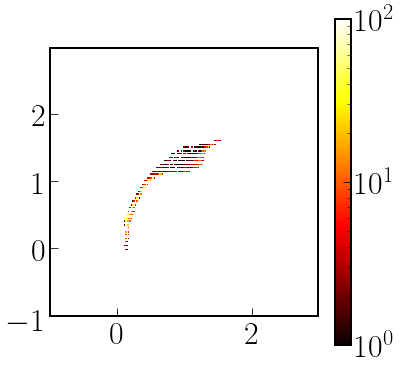

In [467]:
xedges=np.arange(-1,3,0.02)
yedges=np.arange(-1,3,0.02)
hist=np.histogram2d(np.array(rg)-np.array(ig),np.array(gg)-np.array(rg),bins=(xedges,yedges))
z=hist[0].T
im=plt.imshow(z,cmap='hot', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
norm = colors.LogNorm(vmin=1, vmax=100)
im.set_norm(norm)
plt.colorbar()

In [469]:
grg=[]
rig=[]
for gr in np.arange(-1,3,0.02):
    x0=np.inf
    grm=-1
    rim=-1
    for ri in np.arange(-1,3,0.02):
        t=ms[(ms.gr<gr+0.02)&(ms.gr>gr-0.02)]
        if len(t)<500:
            continue
        x2=sum((t.gr-gr)**2+(t.ri-ri)**2)
        if x2<x0:
            x0=x2
            grm=gr
            rim=ri
    if (grm==-1)&(rim==-1):
        continue
    grg.append(grm)
    rig.append(rim)

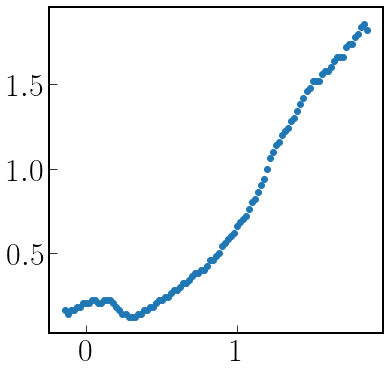

In [470]:
plt.scatter(grg,rig)

In [492]:
len(t)

386630

In [493]:
len(z)

199

In [501]:
range(len(xedges))

range(0, 401)

# 68% fof observable (g,r,i<24) stars

In [553]:
t=ms[(ms.g_psfflux_mag<24)&(ms.r_psfflux_mag<24)&(ms.i_psfflux_mag<24)]
xedges=np.arange(-1,3.01,0.01)
yedges=np.arange(-1,3.01,0.01)
hist=np.histogram2d(t.ri,t.gr,bins=(xedges,yedges))
z=hist[0]
s=[]
for i in range(len(xedges)-1):
    for j in range(len(yedges)-1):
        if z[i][j]>55:
            #s=s+z[i][j]
            s.append(t[(t.ri>xedges[i])&(t.ri<xedges[i+1])&(t.gr>yedges[j])&(t.gr<yedges[j+1])])
mss=pd.concat(s)
#print(s/sum(sum(z)))

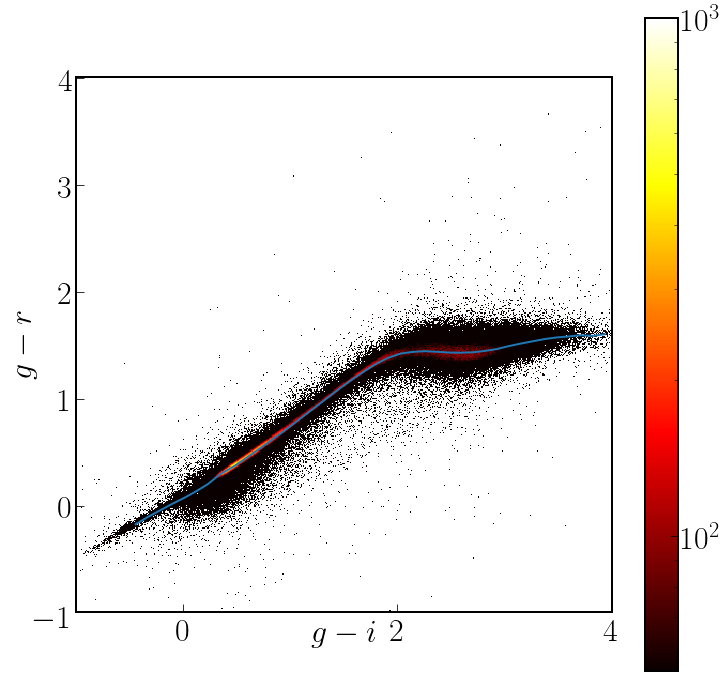

In [699]:
xedges=np.arange(-1,4.02,0.01)
yedges=np.arange(-1,4.02,0.01)
plt.figure(figsize=(12,12))
t=ms[(ms.g_psfflux_mag<24)&(ms.r_psfflux_mag<24)&(ms.i_psfflux_mag<24)]
x1Bin, n1Pts, m1edianBin, s1igGbin = fitMedians(t.g_psfflux_mag-t.i_psfflux_mag,t.gr, -0.5, 4, 40, 0)
#x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(t.gr,t.ri, -0.5, 1.5, 40, 0)
hist=np.histogram2d(t.g_psfflux_mag-t.i_psfflux_mag,t.gr,bins=(xedges,yedges))
z=hist[0].T
#plt.figure(figsize=(10,10))
plt.plot(x1Bin,m1edianBin)
#plt.plot(m2edianBin,x2Bin)
x=np.arange(-1,4,0.1)
#plt.plot(x,line3(x,*popt))
#plt.plot(rig,grg)
#plt.contour(z,levels=[55,100, 500,1000])
plt.xlabel('$g-i$',fontsize=32,labelpad=-30)
im=plt.imshow(z,cmap='hot',origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.ylabel('$g-r$',fontsize=32,labelpad=-5)
norm = colors.LogNorm(vmin=55, vmax=1000)
im.set_norm(norm)
plt.colorbar()

# fit mag diff and color

In [527]:
def line(x,b,k):
    return b+k*x

In [528]:
def line2(x,c0,c1,c2):#,c3):
    return  c0+c1*x+c2*x**2#+c3*x**3

In [529]:
def clip(a,b,t): #HSC-band, S82-band
    popt1, pcov1 =curve_fit(line,a,b)
    print(popt1)
    b2=line(a,*popt1)
    d=b2-b
    plt.figure(figsize=(12,5))
    plt.axes([0.05,0.1,0.4,0.8])
    xedges=np.arange(17,23,0.05)
    yedges=np.arange(17,23,0.05)
    hist=np.histogram2d(a,b,bins=(xedges,yedges))
    z=np.transpose(hist[0])
    plt.imshow(z,cmap='hot',origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],norm=colors.LogNorm(vmin=1, vmax=10000))
    x=np.arange(17,23.5,0.5)
    plt.plot(x,line(x,*popt1),color='tab:blue')
    plt.text(17.5,22,'$y=$'+str(round(popt1[0],3))+'$+$'+str(round(popt1[1],3))+'$x$')
    plt.axes([0.55,0.1,0.4,0.8])
    plt.hist(d,bins=np.arange(-0.2,0.2,0.01))
    print(len(t))
    t=t[(d>np.percentile(d,0.15))&(d<np.percentile(d,99.85))]
    print(len(t))
    return t

In [566]:
def fit(a,b,c):
    d=b-a
    e=b-c
    popt2, pcov2 =curve_fit(line2,e,d)
    xedges=np.arange(-0.5,1.5,0.01)
    yedges=np.arange(-1,1,0.01)
    hist=np.histogram2d(e,d,bins=(xedges,yedges))
    z=np.transpose(hist[0])
    plt.figure(figsize=(12,6))
    plt.imshow(z,cmap='hot',origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],norm=colors.LogNorm(vmin=1, vmax=10000))
    x=np.arange(-0.5,1.5,0.1)
    print(popt2)
    plt.plot(x,line2(x,*popt2),label=r'$y=$'+str(round(popt2[0],4))+'$+$'+str(round(popt2[1],4))+'$x+$'+str(round(popt2[2],4))+'$x^2$')
    plt.legend()

# fit g-band

[0.42177199 0.97705938]
172698
172178


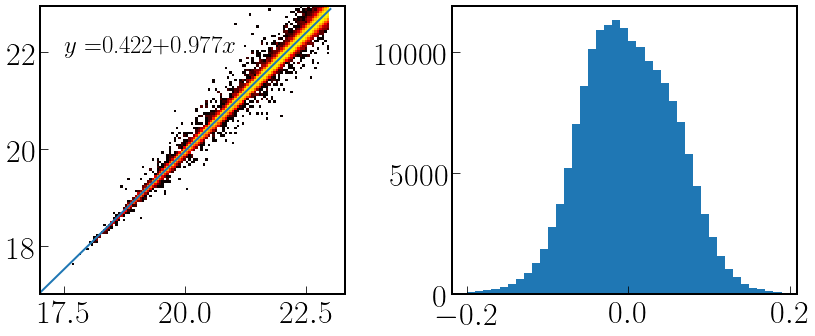

In [564]:
t=mss[(mss.g_psfflux_mag<23)&(mss.psfMag_g<23)&(mss.r_psfflux_mag<23)]
a=t.psfMag_g
b=t.g_psfflux_mag
t=clip(a,b,t)

[-0.01906916  0.02084924 -0.08133338]


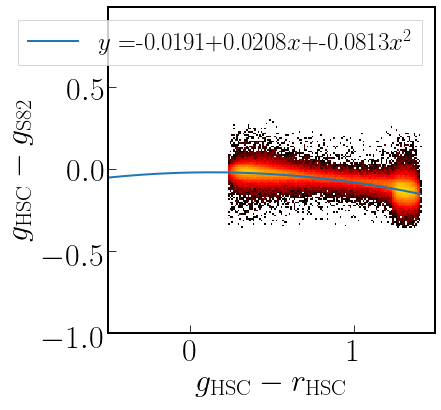

In [567]:
a=t.psfMag_g
b=t.g_psfflux_mag
c=t.r_psfflux_mag
fit(a,b,c)

plt.ylabel(r'$g_{\rm{HSC}}-g_{\rm{S82}}$')
plt.xlabel(r'$g_{\rm{HSC}}-r_{\rm{HSC}}$')
plt.savefig('../Documents/final/photometric/g_v2.png')

[-0.00424036 -0.02740086 -0.05160289]


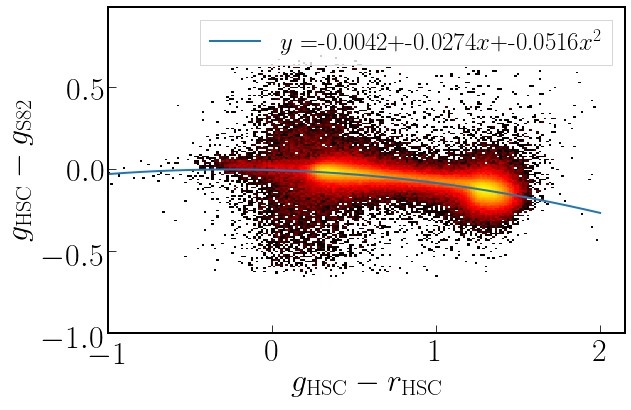

In [364]:
a=t.psfMag_g
b=t.g_psfflux_mag
c=t.r_psfflux_mag
fit(a,b,c)

plt.ylabel(r'$g_{\rm{HSC}}-g_{\rm{S82}}$')
plt.xlabel(r'$g_{\rm{HSC}}-r_{\rm{HSC}}$')
plt.savefig('../Documents/final/photometric/g_v2.png')

# fit r-band

[0.11038562 0.99444622]
253271
252511


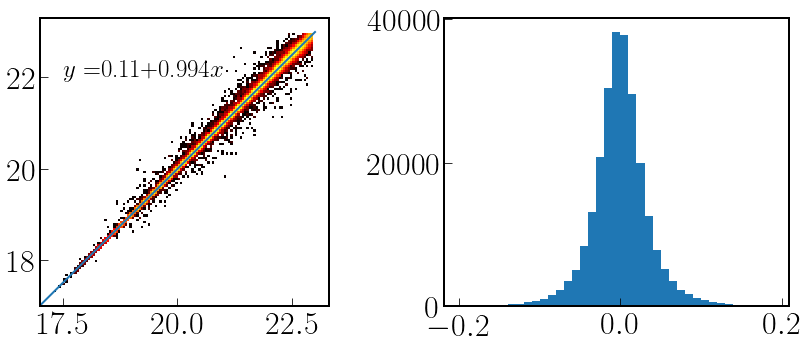

In [568]:
t=mss[(mss.r_psfflux_mag<23)&(mss.psfMag_r<23)&(mss.i_psfflux_mag<23)]
a=t.psfMag_r
b=t.r_psfflux_mag
t=clip(a,b,t)

[-0.01070756  0.02786349 -0.02224166]


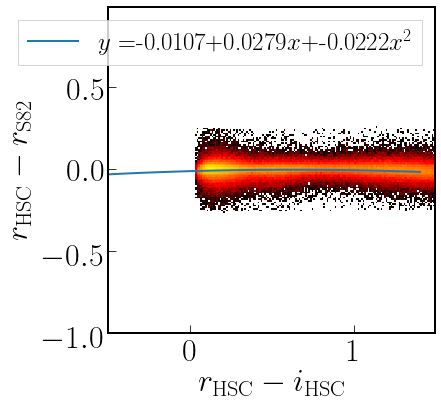

In [569]:
a=t.psfMag_r
b=t.r_psfflux_mag
c=t.i_psfflux_mag
fit(a,b,c)
plt.ylabel(r'$r_{\rm{HSC}}-r_{\rm{S82}}$')
plt.xlabel(r'$r_{\rm{HSC}}-i_{\rm{HSC}}$')
plt.savefig('../Documents/final/photometric/r_v2.png')

[-0.01181826  0.03546558 -0.02470948]


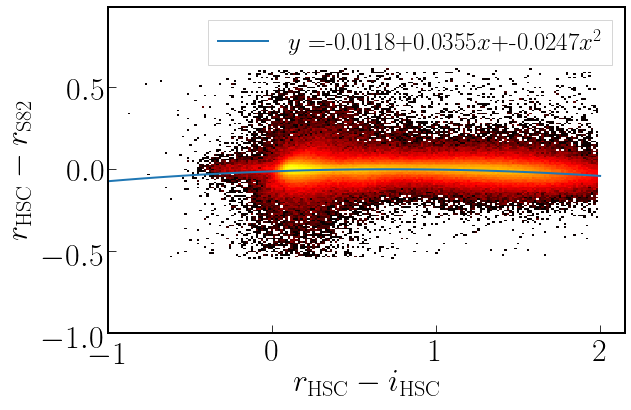

In [366]:
a=t.psfMag_r
b=t.r_psfflux_mag
c=t.i_psfflux_mag
fit(a,b,c)
plt.ylabel(r'$r_{\rm{HSC}}-r_{\rm{S82}}$')
plt.xlabel(r'$r_{\rm{HSC}}-i_{\rm{HSC}}$')
plt.savefig('../Documents/final/photometric/r_v2.png')

# fit i-band

[-0.23615722  1.00938711]
258941
258163


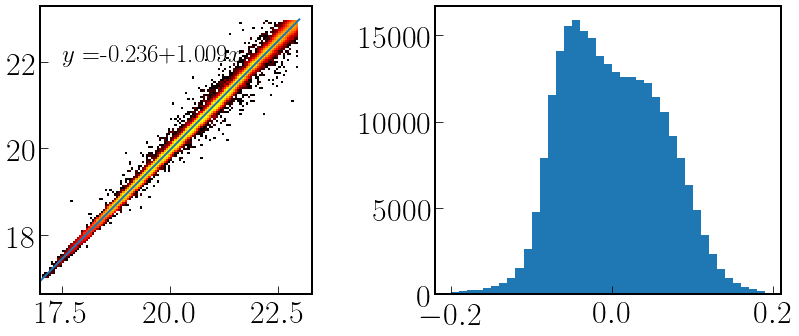

In [570]:
t=mss[(mss.i_psfflux_mag<23)&(mss.psfMag_i<23)&(mss.z_psfflux_mag<23)]
a=t.psfMag_i
b=t.i_psfflux_mag
t=clip(a,b,t)

[ 0.02016005 -0.18922658 -0.07928311]


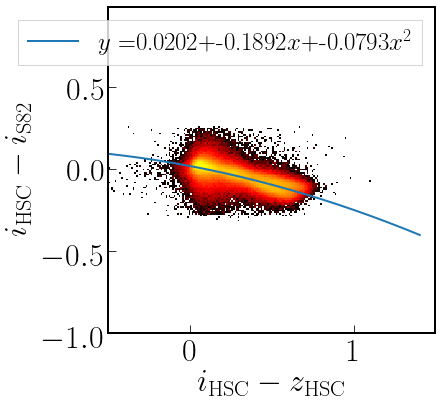

In [571]:
a=t.psfMag_i
b=t.i_psfflux_mag
c=t.z_psfflux_mag
fit(a,b,c)
plt.ylabel(r'$i_{\rm{HSC}}-i_{\rm{S82}}$')
plt.xlabel(r'$i_{\rm{HSC}}-z_{\rm{HSC}}$')
plt.savefig('../Documents/final/photometric/i_v2.png')

[ 0.01812634 -0.19676759 -0.06428846]


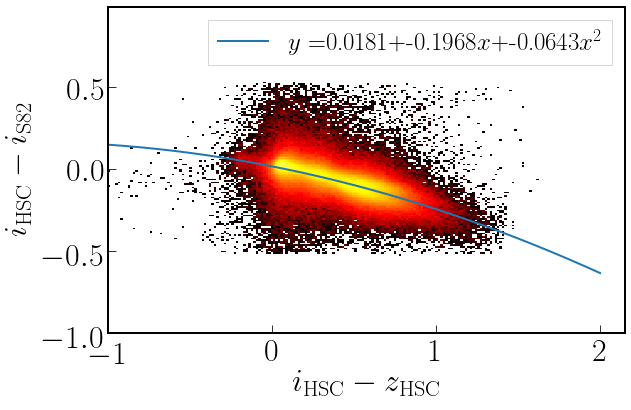

In [368]:
a=t.psfMag_i
b=t.i_psfflux_mag
c=t.z_psfflux_mag
fit(a,b,c)
plt.ylabel(r'$i_{\rm{HSC}}-i_{\rm{S82}}$')
plt.xlabel(r'$i_{\rm{HSC}}-z_{\rm{HSC}}$')
plt.savefig('../Documents/final/photometric/i_v2.png')

# photometric recalibration

In [371]:
ms['gr']=ms.g_psfflux_mag-ms.r_psfflux_mag
ms['ri']=ms.r_psfflux_mag-ms.i_psfflux_mag
ms['iz']=ms.i_psfflux_mag-ms.z_psfflux_mag

In [572]:
ms['gc']=ms.g_psfflux_mag-line2(ms.gr,-0.01906916,  0.02084924, -0.08133338)
ms['rc']=ms.r_psfflux_mag-line2(ms.ri,-0.01070756,  0.02786349, -0.02224166)
ms['ic']=ms.i_psfflux_mag-line2(ms.iz,0.02016005 ,-0.18922658, -0.07928311)

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [573]:
len(ms)

618547

In [574]:
ms=ms[pd.notna(ms.ic)&pd.notna(ms.gc)&pd.notna(ms.rc)]

In [575]:
len(ms)

618547

In [577]:
ms.to_csv('../Downloads/catalog/final/starall.csv',index=False)

# FeH and Distance

In [9]:
def getMainSequenceAbsMag(gi,FeH): 
    """Get absolute magnitude for main sequence stars using eqs. 2, 5, and 7 from
       Ivezic et al. 2008 (ApJ, 684, 287)"""

    # valid for 0.2 < g-i < 4.0 
    Mr0 = -5.06 + 14.32*gi - 12.97*gi**2 + 6.127*gi**3 - 1.267*gi**4 + 0.0967*gi**5
    # offset for metallicity, valid for -2.5 < FeH < 0.2
    Mr = Mr0 + 4.50 - 1.11*FeH - 0.18*FeH**2
    return Mr

def getMainSequenceDistanceKpc(gi,FeH,r): 
    """Get stellar distance in kpc"""
    
    # valid for 0.2 < g-i < 4.0 and -2.5 < FeH < 0.2
    Mr = getMainSequenceAbsMag(gi,FeH)
    # distance in kpc
    Dkpc = 0.01 * 10**(0.2*(r-Mr))
    return Dkpc

def getMainSequenceAppMagforDistanceKpc(gi,FeH,Dkpc): 
    """Get apparent mag array for g-i array, given FeH and Dkpc"""
    # valid for 0.2 < g-i < 4.0 and -2.5 < FeH < 0.2
    Mr = getMainSequenceAbsMag(gi,FeH)
    return Mr + 5*np.log10(100*Dkpc)  

def getPhotomMetallicityBond2010(ug,gr):
    """Get stellar photometric metallicity from the SDSS u, g and r magnitudes
       using eq.A1 from Bond et al. 2010 (ApJ, 716, 1):
       [Fe/H]=A+Bx+Cy+Dxy+Ex2+Fy2+Gx2y+Hxy2+Ix3+Jy3
       with x = (u-g) and y = (g-r), and the best-fit coefficients 
       (A-J) = (-13.13, 14.09, 28.04, -5.51, -5.90, -58.68, 9.14, -20.61, 0.0, 58.20).
       This expression if valid only for g-r<0.6; for redder stars uses [Fe/H] = -0.6.
       Beyond the limits -2.5 and 0.5, use the limits. Add Gaussian noise with rms=0.1"""

    # aux variables
    x = ug
    y = gr
    xy = x*y
    x2 = x*x
    y2 = y*y
    x2y = x*x*y
    xy2 = x*y*y
    y3 = y*y*y

    A = -13.13  
    B =  14.09
    C =  28.04
    D =  -5.51
    E =  -5.90
    F = -58.68
    G =   9.14
    H = -20.61
    I =  58.20
    FeH = A + B*x + C*y + D*xy + E*x2 + F*y2 + G*x2y + H*xy2 + I*y3 
    # add Gaussian noise (rms=0.1 dex) 
    np.random.seed(666) 
    b = np.random.randn(FeH.shape[0])  # Gaussian
    FeH = FeH + 0.1*b
    FeH[gr>0.6] = -0.6
    FeH[FeH < -2.5] = -2.5
    FeH[FeH > 0.5] = 0.5
    return FeH    

In [593]:
ms['FeH']=getPhotomMetallicityBond2010(ms.psfmag_u-ms.gc,ms.gc-ms.rc)

In [595]:
ms['Dkpc']=getMainSequenceDistanceKpc(ms.gc-ms.ic,ms.FeH,ms.rc)

In [650]:
ms=pd.read_csv('../Downloads/catalog/final/starall.csv')

In [601]:
err = np.random.randn(ms[ms.Dkpc>6.25].shape[0])
FeH=ms.FeH
FeH[(ms.Dkpc>6.25)&(ms.gc-ms.rc<0.6)]=-1.45+0.41*err
FeH[FeH < -2.5] = -2.5
FeH[FeH > 0.5] = 0.5
ms['FeH']=FeH
ms['Dkpc']=getMainSequenceDistanceKpc(ms.gc-ms.ic,ms.FeH,ms.rc)

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  

In [610]:
#err = np.random.randn(ms[ms.Dkpc>6.25].shape[0])
FeH=ms.FeH
FeH[(ms.Dkpc>6.25)&(ms.gc)]=-1.45#+0.41*err
FeH[FeH < -2.5] = -2.5
FeH[FeH > 0.5] = 0.5
ms['FeH']=FeH
ms['Dkpc']=getMainSequenceDistanceKpc(ms.gc-ms.ic,ms.FeH,ms.rc)

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  

In [612]:
ms.to_csv('../Downloads/catalog/final/starall2.csv',index=False)

In [632]:
min(ms[ms.FeH==-1.45].Dkpc)

4.677382730039977

# 0 original FeH and Distance

In [654]:
ms['ug']=ms.psfmag_u-ms.g_psfflux_mag
ms['gr']=ms.g_psfflux_mag-ms.r_psfflux_mag
ms['gi']=ms.g_psfflux_mag-ms.i_psfflux_mag
ms['ri']=ms.r_psfflux_mag-ms.i_psfflux_mag
ms['iz']=ms.i_psfflux_mag-ms.z_psfflux_mag

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [652]:
ms=ms.iloc[:,range(85)]

In [665]:
ms['FeH']=getPhotomMetallicityBond2010(ms.ug,ms.gr)
ms['Dkpc']=getMainSequenceDistanceKpc(ms.gi,ms.FeH,ms.r_psfflux_mag)

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [672]:
ms.to_csv('../Downloads/catalog/final/starall.csv',index=False)

In [667]:
mss=ms[ms.gi>0.2]

In [671]:
mss.to_csv('../Downloads/catalog/final/0/starall.csv',index=False)

In [7]:
def newFeH(ug,gr,gi,r):
    FeH=getPhotomMetallicityBond2010(ug,gr)
    Dkpc=getMainSequenceDistanceKpc(gi,FeH,r)
    FeH[(Dkpc>6.25)]=-1.45
    return FeH

In [689]:
def newFeH2(ug,gr,gi,r):
    FeH=getPhotomMetallicityBond2010(ug,gr)
    Dkpc=getMainSequenceDistanceKpc(gi,FeH,r)
    err = np.random.randn(FeH[(gr<0.6)&(Dkpc>6.25)].shape[0])
    FeH[(gr<0.6)&(Dkpc>6.25)]=-1.45+0.41*err
    FeH[FeH < -2.5] = -2.5
    FeH[FeH > 0.5] = 0.5
    return FeH

In [24]:
def newFeH3(ug,gr,gi,r):
    FeH=getPhotomMetallicityBond2010(ug,gr)
    Dkpc=getMainSequenceDistanceKpc(gi,FeH,r)
    FeH[(Dkpc>6.25)]=-1.95
    return FeH

In [25]:
def newFeH4(ug,gr,gi,r):
    FeH=getPhotomMetallicityBond2010(ug,gr)
    Dkpc=getMainSequenceDistanceKpc(gi,FeH,r)
    FeH[(Dkpc>6.25)]=-0.95
    return FeH

# 1 no photometric recalibration with new fixed FeH (-1.45)

In [675]:
ms['FeH']=newFeH(ms.ug,ms.gr,ms.gi,ms.r_psfflux_mag)
ms['Dkpc']=getMainSequenceDistanceKpc(ms.gi,ms.FeH,ms.r_psfflux_mag)

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [677]:
mss=ms[ms.gi>0.2]

In [681]:
mss.to_csv('../Downloads/catalog/final/1/starall.csv',index=False)

# 2 photometric recalibration with new fixed FeH (-1.45)

In [682]:
ms['gc']=ms.g_psfflux_mag-line2(ms.gr,-0.01906916,  0.02084924, -0.08133338)
ms['rc']=ms.r_psfflux_mag-line2(ms.ri,-0.01070756,  0.02786349, -0.02224166)
ms['ic']=ms.i_psfflux_mag-line2(ms.iz,0.02016005 ,-0.18922658, -0.07928311)

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [684]:
ms['ug']=ms.psfmag_u-ms.gc
ms['gr']=ms.gc-ms.rc
ms['gi']=ms.gc-ms.ic
ms['ri']=ms.rc-ms.ic

In [5]:
ms=pd.read_csv('../Downloads/catalog/final/2/starall.csv')

In [10]:
ms['FeH']=newFeH(ms.ug,ms.gr,ms.gi,ms.rc)
ms['Dkpc']=getMainSequenceDistanceKpc(ms.gi,ms.FeH,ms.rc)

In [12]:
ms['pmdec_cl'][ms.g_psfflux_mag-ms.r_psfflux_mag<0.6]=ms[ms.g_psfflux_mag-ms.r_psfflux_mag<0.6].pmdec_cl-0.5437
ms['pmdec_cl'][ms.g_psfflux_mag-ms.r_psfflux_mag>0.6]=ms[ms.g_psfflux_mag-ms.r_psfflux_mag>0.6].pmdec_cl+0.1266
ms['pmra_cl'][ms.g_psfflux_mag-ms.r_psfflux_mag<0.6]=ms[ms.g_psfflux_mag-ms.r_psfflux_mag<0.6].pmra_cl+0.0559
ms['pmra_cl'][ms.g_psfflux_mag-ms.r_psfflux_mag>0.6]=ms[ms.g_psfflux_mag-ms.r_psfflux_mag>0.6].pmra_cl-0.0385

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imp

In [14]:
ms['pmdec_cl2']=0
ms['pmra_cl2']=0

In [15]:
ms['pmdec_cl2'][ms.gr<0.6]=ms[ms.gr<0.6].pmdec_cl+0.538
ms['pmdec_cl2'][ms.gr>0.6]=ms[ms.gr>0.6].pmdec_cl-0.116
ms['pmra_cl2'][ms.gr<0.6]=ms[ms.gr<0.6].pmra_cl-0.050
ms['pmra_cl2'][ms.gr>0.6]=ms[ms.gr>0.6].pmra_cl+0.037

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imp

In [16]:
len(ms)

610422

In [18]:
ms.to_csv('../Downloads/catalog/final/4/starall.csv',index=False)

# 3 photometric recalibration with new FeH (-1.45+-0.41)

In [690]:
ms['FeH']=newFeH2(ms.ug,ms.gr,ms.gi,ms.rc)
ms['Dkpc']=getMainSequenceDistanceKpc(ms.gi,ms.FeH,ms.rc)

In [694]:
mss=ms[ms.gi>0.2]

In [696]:
mss.to_csv('../Downloads/catalog/final/3/starall.csv',index=False)

# 5 photometric recalibration with new fixed FeH (-1.95)

In [7]:
ms=pd.read_csv('../Downloads/catalog/final/4/starall.csv')

In [26]:
ms['FeH']=newFeH3(ms.ug,ms.gr,ms.gi,ms.rc)
ms['Dkpc']=getMainSequenceDistanceKpc(ms.gi,ms.FeH,ms.rc)

In [28]:
ms.to_csv('../Downloads/catalog/final/5/starall.csv',index=False)

# 6 photometric recalibration with new fixed FeH (-0.95)

In [29]:
ms['FeH']=newFeH4(ms.ug,ms.gr,ms.gi,ms.rc)
ms['Dkpc']=getMainSequenceDistanceKpc(ms.gi,ms.FeH,ms.rc)

In [30]:
ms.to_csv('../Downloads/catalog/final/6/starall.csv',index=False)

In [8]:
mb=ms[ms.gr<0.6]

In [18]:
t=mb[mb.Dkpc<6.25]

(array([1086.,   24.,   25.,   51.,   82.,  109.,  189.,  270.,  374.,
         650., 3238.,  914.,  969.,  988.,  984.,  821.,  661.,  561.,
         396.,  227.,  124.,  107.,   67.,   47.,   30.,   29.,   23.,
          15.,   28.]),
 array([-2.50000000e+00, -2.40000000e+00, -2.30000000e+00, -2.20000000e+00,
        -2.10000000e+00, -2.00000000e+00, -1.90000000e+00, -1.80000000e+00,
        -1.70000000e+00, -1.60000000e+00, -1.50000000e+00, -1.40000000e+00,
        -1.30000000e+00, -1.20000000e+00, -1.10000000e+00, -1.00000000e+00,
        -9.00000000e-01, -8.00000000e-01, -7.00000000e-01, -6.00000000e-01,
        -5.00000000e-01, -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
        -1.00000000e-01,  2.22044605e-15,  1.00000000e-01,  2.00000000e-01,
         3.00000000e-01,  4.00000000e-01]),
 <a list of 29 Patch objects>)

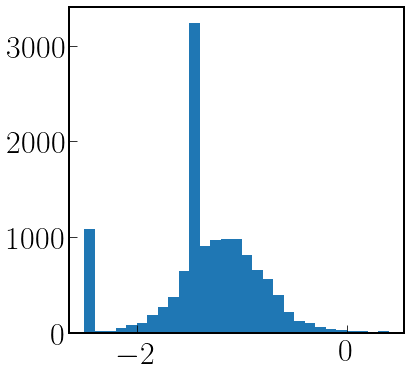

In [19]:
plt.hist(t.FeH,bins=np.arange(-2.5,0.5,0.1))

In [15]:
t.FeH

2625     -2.500000
3469     -2.500000
3748     -2.500000
3779     -2.500000
4118     -1.727593
4776     -2.500000
5031     -2.500000
6047     -1.828412
6128     -1.505736
6158     -1.315082
6186     -1.504968
6229     -2.500000
6342     -2.000829
6609     -1.537378
6739     -1.534880
6871     -1.605559
7203     -1.801980
7237     -2.500000
7285     -2.500000
7288     -2.500000
7314     -2.500000
7388     -1.450000
7459     -1.450000
7532     -1.450000
7645     -1.719099
7814     -1.170623
7995     -1.450000
8024     -1.450000
8055     -1.450000
8461     -2.500000
            ...   
599574   -2.500000
599591   -2.500000
599601    0.500000
599630   -0.282587
599727   -2.500000
600006   -2.500000
600471    0.457187
601372    0.500000
601438   -2.500000
601462   -2.500000
601695   -2.500000
601806   -2.500000
601807   -2.500000
602091   -2.500000
602133   -2.500000
602156   -2.500000
602214   -1.262765
602293   -2.500000
602301   -2.500000
602323   -2.500000
602523   -2.500000
602896   -2.